In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, asc, desc

In [5]:
# Create the connection engine 'hawaii.sqlite' database file
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
inspector = inspect(engine)

In [10]:
#get a list of column names in measurement
mcolumns = inspector.get_columns('measurement')
for c in mcolumns:
    print(c['name'], c['type'])
#columns for measurement

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
#get a list of column names in station
scolumns = inspector.get_columns('station')
for c in scolumns:
    print(c['name'], c['type'])
#columns for station

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [14]:
#test area
#test area
sel = [Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
results5 = (session.query(*sel).filter(func.strftime("%Y-%m-%d", Measurement.date) >= startdate).filter(func.strftime("%Y-%m-%d", Measurement.date) <= enddate).group_by(Measurement.date).all())
    
se_data = []
for result in results5:
    j_dict = {}
    j_dict["Date"] = results5[0]
    j_dict["Low Temp"] = results5[1]
    j_dict["Avg Temp"] = results5[2]
    j_dict["High Temp"] = results5[3]
    se_data.append(j_dict)


print(se_data)




NameError: name 'startdate' is not defined

Vacation Range

In [13]:
# calculate vacation range - October 7 thru October 14
start_date = dt.date(2020, 10, 7) 
end_date = dt.date(2020, 10, 14)


# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [15]:
# determine latest date  in the Measurement database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [16]:
# create variable for last 12 month period of the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query date:", query_date)

Query date: 2016-08-23


In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
data1 = (session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).order_by(Measurement.date).all())

In [18]:
# create dataframe with only date and prcp with date as index
df1 = pd.DataFrame(data1)
df1.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


In [19]:
#remove NaN values set index and sort index by date
df2 = df1.dropna(how="any")
df2.set_index('date', inplace=True)
df2.sort_index(ascending=True)
df2.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


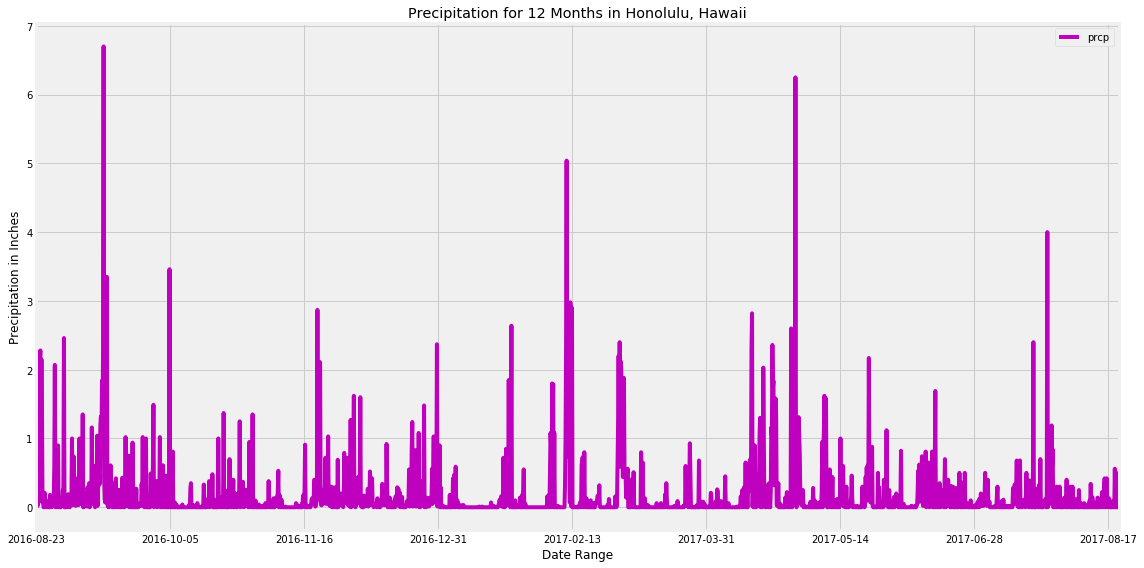

In [20]:
#plot prcp by date
fig, ax = plt.subplots(figsize = (16, 8))
df2.plot(ax = ax, x_compat = True, color='m')

#set title and labels
ax.set_xlabel("Date Range")
ax.set_ylabel("Precipitation in Inches")
ax.set_title("Precipitation for 12 Months in Honolulu, Hawaii")

#save figure
plt.savefig("plot1.png")

#plot figure
plt.tight_layout()
plt.show()


In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df2.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [22]:
# Design a query to show how many stations are available in this dataset?
staloc=session.query(Station).group_by(Station.station).count()
print(f"Total number of stations in this dataset is {staloc}.")

Total number of stations in this dataset is 9.


In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stacnt = (session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all())
#print list of activity of stations
stacnt

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
mactsta = (session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first())
print(f"The most active station was {mactsta[0]} with {mactsta[1]} recordings.")

The most active station was USC00519281 with 2772 recordings.


In [25]:
# collect temperature data for most active station
macttemp =session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station==mactsta[0]).all()
print(f"The lowest temperature recorded at {mactsta[0]} was: {macttemp[0][0]} Fahrenheit")
print(f"The highest temperature recorded at {mactsta[0]} was: {macttemp[0][1]} Fahrenheit")
print(f"The average temperature recorded at {mactsta[0]} was: {round(macttemp[0][2], 1)} Fahrenheit")

The lowest temperature recorded at USC00519281 was: 54.0 Fahrenheit
The highest temperature recorded at USC00519281 was: 85.0 Fahrenheit
The average temperature recorded at USC00519281 was: 71.7 Fahrenheit


In [26]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# query for the last year of temperature data for one year
tdata = (session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= query_date).filter(Measurement.station == mactsta[0]).order_by(Measurement.date).all())

In [27]:
#convert query object to data frame
df3 = pd.DataFrame(tdata)
df3 = df3.set_index('date')

#sort by date
df3 = df3.sort_index(ascending=True)

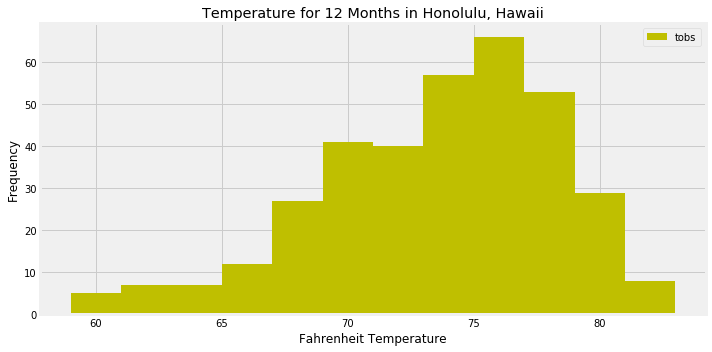

In [28]:
#plot histogram
fig, ax = plt.subplots(figsize=(10,5))
df3.plot.hist(bins = 12, ax = ax, color='y')

#set labels
ax.set_xlabel("Temperature in Fahrenheit")
ax.set_ylabel("Frequency")
ax.set_title("Temperature for 12 Months in Honolulu, Hawaii")

#save figure
plt.savefig("plot2.png")

plt.tight_layout()
plt.show()


## Bonus Challenge Assignment

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-10-07', '2016-10-14'))


[(71.0, 77.46938775510205, 82.0)]


In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [32]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [34]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [35]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [36]:
# Plot the daily normals as an area plot with `stacked=False`
